# https://www.kaggle.com/code/vprokopev/mean-likelihood-encodings-a-comprehensive-study/

# Mean (likelihood) encodings: a comprehensive study

## Mean (likelihood) encoding for categorical variables with high cardinality and feature interactions: a comprehensive study with Python

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

2. High cardinality categorical features
Features with a lot of different categories require different approaches to encoding then low cardinality features. One-hot encoding will create a huge amount of columns and harm the column sampling process in tree methods: one-hot encoded columns will overcrowd all other predictors and make high cardinality feature to be way too disproportionally important for a model. Label encoding will be hard to process for a model, because of how random it will look and how many splits will be needed.

2.1 Feature interactions usually cause high cardinality
In many settings, hand-picked feature interactions can be quite useful. They help a model to extract information from the data with fewer splits and improve its performance. By combining of several categorical variables, or binned continuous variables, we usually create a new high-cardinality feature. That creates even more need for a proper encoding scheme for those.

3. Popular encodings for categorical variables, advantages and disadvantages for tree models
3.1 One-hot encoding
One-hot encoding maps each category to a vector in  R(n−1) or  R(n−k) where  n>k>1
  if we want to skip some categories. Each vector in a vector contains one '1' and all the rest of its values are '0'. That encoding is usually used in linear models and is not the best choice for tree models.

Advantages:

Each category is properly separated from others. We put no assumptions about the relationships between categories with that encoding, so the model is less biased in that sense.

Very easy to implement.

Disadvantages:

For high cardinality features, one hot encoding produces a lot of columns. It slows down learning significantly and if we the model randomly samples a fraction of features for each tree or split, then the chances of one-hot encoded feature to be present in a sample are artificially increased, and chances of other (not one-hot encoded) variables to be considered on a split/tree are reduced. That makes a model treat one-hot encoded features as more useful than not one-hot encoded.

On each split, trees can only separate one category from the others. Trees have to put every category in a separate bin, there is no other way to split a one hot encoded column but between 0 and 1. That leads to more splits needed to achieve same train accuracy as other, more compact encodings. That again, slowers learning and prevents trees from putting similar categories together in one bin, which might reduce the quality of the model.

3.2 Label and frequency encoding
Label encoding is a mapping of each category to some number in  R1
 . Numbers (labels) are usually chosen in a way that has no or almost no meaning in terms of relationships between categories. So, categories encoded with numbers that close are to each other (usually) are not more related then categories encoded with numbers that far away from each other.

Frequency encoding is a way to utilize frequencies of categories as labels. It can help if frequency correlates with the target and also, it can help the model to understand that smaller categories are less trustworthy then bigger ones, especially when frequency encoding is used parallel with other type of encoding.

Advantages (compared to one-hot encoding):

Faster learning than with one-hot representations. Numbers in  R1
  are way more compact representations then vectors in  Rn−1
  used in one-hot encoding, that leads to fewer features for trees, which leads to faster learning.

Less splits needed, means a more robust model. Unlike with one hot encoding, here trees can separate several categories at a time (with one-hot it is always 1).

Easy to implement.

Disadvantages:
Bias. Label encoding is biased in a way that assumes a particular ordered relationship between categories. In reality, due to randomness in assigning labels, that relationship does not exist.

Nonlinearity towards target variable, more splits. At each binary split, tree models need to find a value of a variable that separates the target as good as possible. It is way harder to achieve when feature and target have almost zero linear dependencies. Trees have to do a lot of splits to put individual categories in separate buckets to continue to improve train loss.

4. Mean target encoding
Plain mean target encoding can be viewed as a variation of label encoding, that is used to make labels correlate with the target. For each category, we set it's label to the mean value of a target variable on a training data.

labelc=pc
Where pc
 is a mean target value for the category c
.

We do not use test data to estimate encodings, for the obvious reason: we should treat test data like we do not know target for it.

Advantages (compared to label encoding):

Fewer splits, faster learning. Trees can utilize the linear relationships between labels and target. This is especially useful when working with high cardinality categorical features: it is hard for a model to put every small category into a separate bucket, but if a lot of small categories can be put in one bin together based on their mean target value, then trees can learn way faster.

Less bias, since now labels have more meaning: closer labels mean closer categories in terms of the mean target variable.

Disadvantages:

Harder to construct and do validation.
Easy to overfit if regularisation is not used.
4.1 Overfitting with mean target encoding
When we dealing with high cardinality features, a lot of categories have a small number of samples in them. Many of those categories will look like great predictors for a model, when in fact they are not.

Consider a binary target  Y
 , and let's suppose that it's distribution for some category is completely random: </br>

P(Y|category1)=Bernoulli(0.5)

That implies that the category has 0 predicting power (when considered by itself).

But, let's say now we have 5 examples in train data with that category (equivalent to sampling 5 times from the distribution Bernoulli(0.5)), what is the probability category will look like a good predictor? Probability to get all five 1's or all five 0's is 0.0625. So, if we have 100 categories like this one, with 5 samples and 0 predicting power, we expect at least 6 of them to have a target of all 0'r or target of all 1's.

Then, if we add combinations where four values of the target are the same (still looks like a great predictor), the probability of that happening equals 0.375! More than every third category with 0 predicting power, on a small sample size of 5 samples will look like a decent predictor.

Trees will put those categories in a separate leafs and will learn to predict extreme values for those categories. Then, when we get the same categories in test data, most of them will not have the same target distribution, and model predictions will be wrong.

4.2 Using the prior probability for regularisation
Let's keep using a binary response variable as an example. Regression tasks will all have the same intuitions as binary classification behind them.

Simpliest regularisation technique is to move encodings of rare categories closer to the dataset target mean, both on train and test data. That way we hope that the model will be less likely learn very high or very low probabilities for small categories: their encodings will now be closer to the middle and kind of blend with encodings for categories that have a smaller mean target value.

Now encoding for each category in both train and test data will be estimated as:

labelc=(pc∗nc+pglobal∗α)(nc+α)
 
Where  pc
  is a target mean for a category,  nc
  is a number of samples in a category,  pglobal
  is a global target mean and  α
  is a regularisation parameter that can be viewed as a size of a category you can trust.

Drawbacks are obvious, encoding is still just pseudo continuous, every category will be encoded with a distinct real number, that still allows the model to put any category in a distinct leaf and set an extreme target probability for the leaf. It's is just a bit harder for the model to do it now, because the encodings for those categories are closer to the middle, instead of also having extreme values, so the model needs more splits to overfit.

What we need is to somehow randomize encodings inside a category, so that those small categories with extreme target values will be hard to put in a distinct bin, but bigger categories that we cat trust will still have its encodings close the mean target value for them. Randomise, but still, let model learn that there is a correlation between category encoding and the target variable.

4.3 K-fold regularisation for mean encodings
The idea behind k-fold regularisation is to use just a part of examples of a category to estimate the encoding for that category. Split the data into k-folds and for each example, estimate it's encoding using all folds except the one that the example belongs to. We can use the global mean regularisation in combination with k-fold for more robust encoding.

Now the encoding estimation is a 3-step procedure:

Split train data into k folds.
Then, for each sample:

Exclude the fold that contains a sample.

Estimate encoding for the sample with the data that left using equation above

Notice that k-fold regularisation is only performed for training data, test labels are still estimated from all training examples, since we do not supposed to know the labels to the test data and definitely cannot use them for estimating encodings.

I believe that the best number of folds is between 3 and 6, depending on how much randomization you want to achieve. Fewer folds for stronger randomization in terms of bigger variance of labels for each category.

4.4 Expanding mean regularisation
Process:

Fix some random permutation of rows (samples)
Moving from top to bottom, for each example, estimate the encoding using target mean of all the examples before the estimated one. An estimated example is not used.
That way we create even more randomization of encoding inside each category. Every train sample in each category now estimated from a different subsample of train data. Smaller categories got more randomization, bigger categories got less randomization and more samples encoded with numbers closer to the category mean, by the law of large numbers. That is a very useful property because overfitting arises mostly because of those smaller categories.

The main drawback is that sometimes this regularisation can add to much noise and make a lot of categories useless. Examples of that happening will be shown later in this article.

5. Datasets
More datasets will be extended in the future, but for now I used those six to study the effectiveness of mean encoding compared to other encoding methods and compare different regularisation schemes:

IMDB movie revenue. 872 samples. Regression task, a small dataset, mixed high and low cardinality features.
Video Game Sales. 16291 samples. Regression task, bigger dataset, mixed high and low cardinality features.
World Bank poverty prediction. 37560 samples. Classification, big dataset, features of a lower cardinality then other datasets.

World Bank poverty prediction (interactions). 37560 samples. Classification, big dataset, high cardinality features are created by feature interactions.
Home Credit Default Risk. 109742 samples. Classification, big dataset, a mix of high and low cardinality features. Low cardinality features are created by feature interactions.
Avazu Click-Through Rate Prediction. 100000 samples. Classification, big dataset, extremely high cardinality features.
I changed a bit in every dataset, created some new features using feature interactions so that I have more high cardinality categorical variables to work with. Also, I deleted all numerical columns (or binned them), for clearer experiment results and in some, used just a part of the data.

6. Encoding tests
On every dataset, I trained a sklearn implementation of gradient boosted trees, made a train/test split, capture the best test score the model achieved and the number of iteration that score was achieved at.

I also provide two important statistics about the mean encodings that will help us understand how much randomness each regularisation adds to the train data.

6.1 Testing procedure
Train/test split
Encode all columns using the same method. When dealing with mean encoding regularisations, regularise only train data.
Test a gradient boosted trees model from sklearn several times, with a different number of learners.
Summarise the results
6.2 Encoding statistics
Encoding variability inside categories (EV). Describes the variation of encodings of individual samples inside one category. Obviously, when we do not use regularisation and encode all samples with one number (adjusted mean), this score is equals to 0. When we use k-fold or expanding mean methods, the score is > 0.


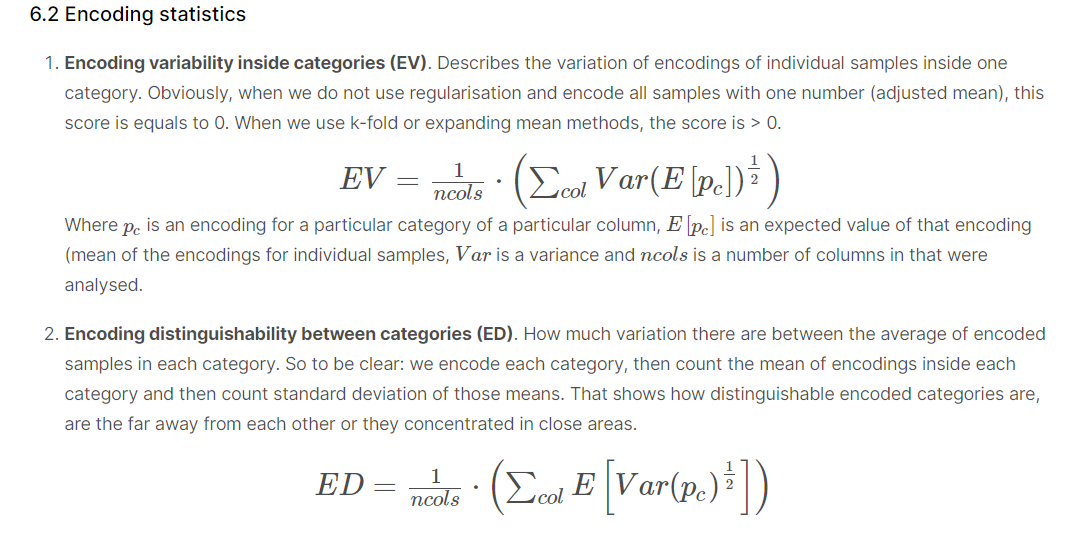
